In [1]:
import os
import re

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf

if os.getcwd().split(os.sep)[-1] == 'notebook':
    os.chdir('..')

from cma import CMA
from notebook.utils import plot_3d_surface, plot_2d_contour, draw_confidence_ellipse

In [2]:
tf.random.set_seed(444)

def fitness_fn(x):
    """
    Six-Hump Camel Function
    https://www.sfu.ca/~ssurjano/camel6.html
    """
    return (
        (4 - 2.1 * x[:,0]**2 + x[:,0]**4 / 3) * x[:,0]**2 +
        x[:,0] * x[:,1] +
        (-4 + 4 * x[:,1]**2) * x[:,1]**2
    )

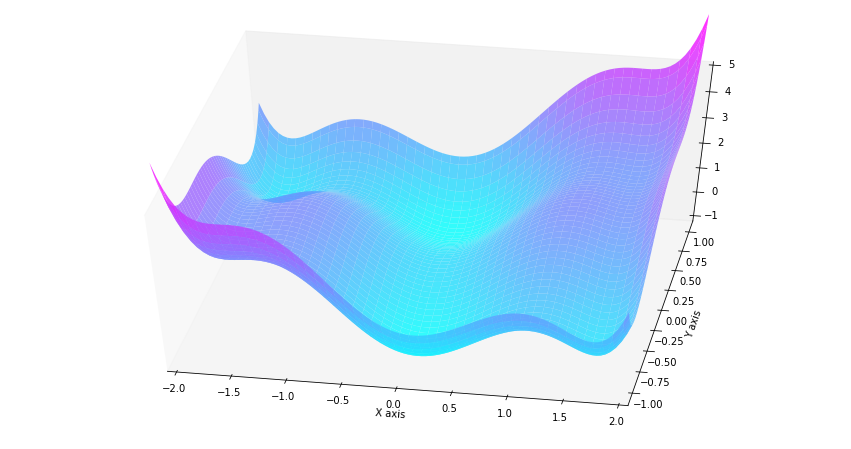

In [3]:
plot_3d_surface(
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
    zlim=[-1.1, 5],
    view_init=[50, -80],
);

In [4]:
cma = CMA(
    initial_solution=[1.5, -0.4],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
    store_trace=True,
)
cma.search();

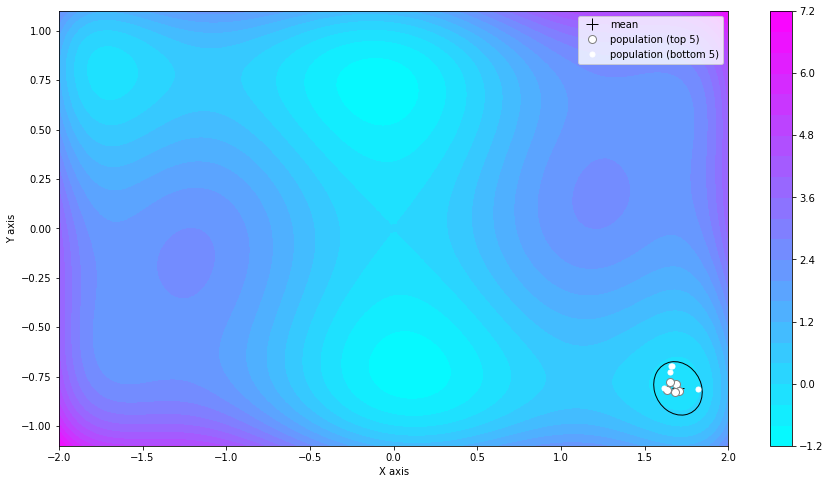

In [9]:
generation = 8
trace = cma.trace[generation]
m = trace['m']
B = trace['B']
l = trace['σ']**2 * np.diagonal(trace['D'])**2
population = trace['population']

f, ax = plot_2d_contour(
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
    mean=m,
    solutions=population,
)

draw_confidence_ellipse(
    ax,
    mean=m,
    eigenvectors=B,
    eigenvalues=l,
    confidence=0.95,
)

In [6]:
def schwefel_fitness_fn(x):
    """
    Schwefel Function
    https://www.sfu.ca/~ssurjano/schwef.html
    """
    dimension = tf.cast(tf.shape(x)[1], tf.float64)
    return 418.9829 * dimension - tf.reduce_sum(x * tf.sin(tf.sqrt(tf.abs(x))), axis=1)

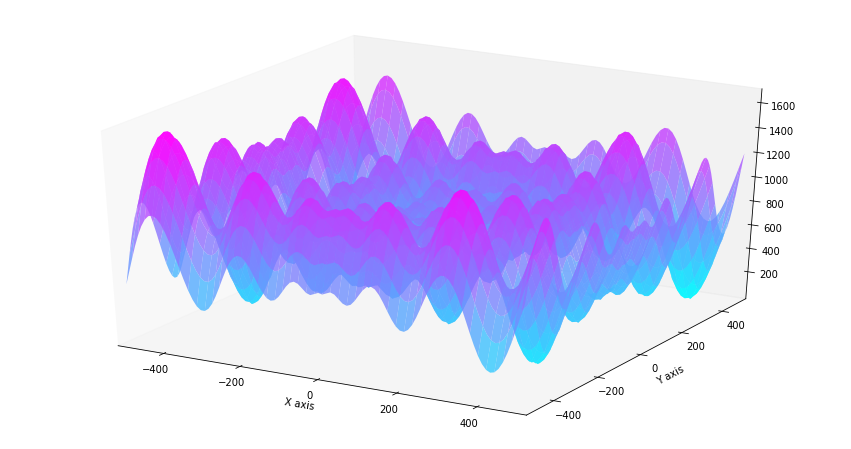

In [7]:
plot_3d_surface(
    schwefel_fitness_fn,
    xlim=[-500, 500], 
    ylim=[-500, 500],
);

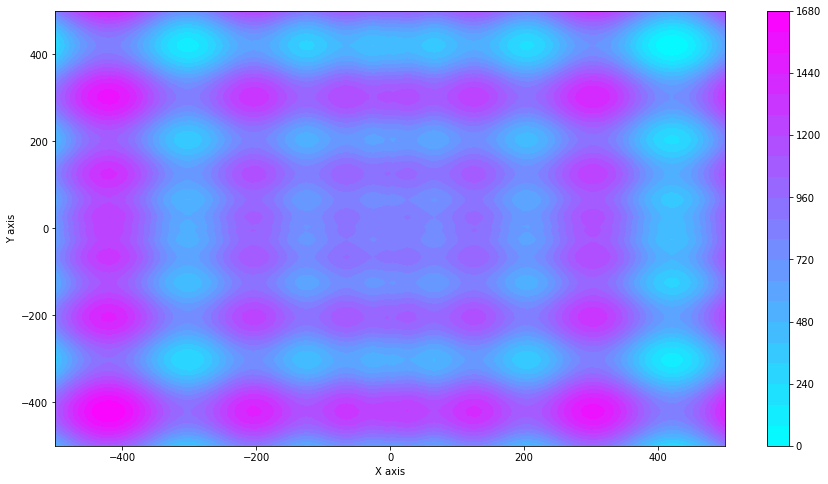

In [8]:
f, ax = plot_2d_contour(
    schwefel_fitness_fn,
    xlim=[-500, 500], 
    ylim=[-500, 500],
);